In [1]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append("../../emittance/")

from normalized_scalar_model import model
from training import train
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoNormal

k = torch.load("kappa.pt")[:-1]
beam_size = torch.load("variances.pt")

In [2]:
beam_size.shape

torch.Size([20, 3, 2])

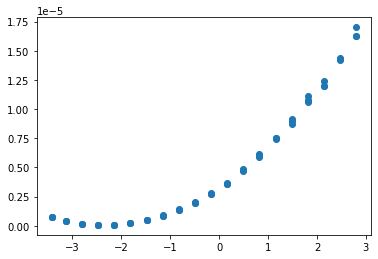

In [3]:
fig,ax = plt.subplots()
ax.plot(k[:,:3].flatten(), beam_size[...,0].flatten(),'o')

In [4]:
test_k = torch.linspace(k.min(),k.max(),100).reshape(1,1,-1)
train_k = k[:,:3].flatten().reshape(1,1,-1)
train_y = beam_size[...,0].flatten().reshape(1,1,-1)

d = torch.tensor(2.84 + 0.54)
l = torch.tensor(0.12)
train_k_norm = 1.0 + d * l * train_k
test_k_norm = 1.0 + d * l * test_k

A = torch.max(train_y).sqrt()
train_y_norm = train_y / A ** 2


import pyro
from pyro import poutine
import time
posterior_module = pyro.nn.PyroModule("model")
posterior_module.guide = AutoNormal(poutine.block(model, hide=['bm']))
l = train(model,
          posterior_module.guide,
          train_k_norm.double(),
          d.double(),
          A.double(),
          train_y_norm.double(),
          lr=0.1,
          n_steps=1000,
          verbose=True)

C:\ProgramData\Miniconda3\envs\phase_space_reconstruction\lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'bm'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


[iter 0]  loss: 24757.8418
[iter 50]  loss: 242.7958
[iter 100]  loss: 103.1689
[iter 150]  loss: 90.1170
[iter 200]  loss: -0.0077
[iter 250]  loss: 23.8575
[iter 300]  loss: 4.6299
[iter 350]  loss: -53.7068
[iter 400]  loss: -46.1123
[iter 450]  loss: -49.1169
[iter 500]  loss: -50.0278
[iter 550]  loss: -53.0607
[iter 600]  loss: -38.7624
[iter 650]  loss: -36.8843
[iter 700]  loss: -55.2055
[iter 750]  loss: -55.7578
[iter 800]  loss: -53.4166
[iter 850]  loss: -54.7996
[iter 900]  loss: -53.5545
[iter 950]  loss: -55.9117


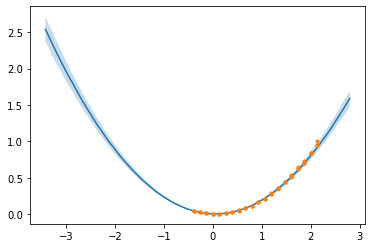

In [5]:
posterior_predictive = Predictive(model, num_samples=800, parallel=True, guide=posterior_module.guide)
posterior_samples = posterior_predictive(test_k, d, A)

def get_stats(samples):
    mean = torch.mean(samples, dim=0)
    l = torch.quantile(samples, 0.05, dim=0)
    u = torch.quantile(samples, 0.95, dim=0)
    return mean, l, u


fig, ax = plt.subplots()
m, l, u = get_stats(torch.exp(posterior_samples["obs"].squeeze()))
ax.plot(test_k.squeeze().cpu(), m.cpu())
ax.fill_between(test_k.squeeze().cpu(), l.cpu(), u.cpu(), alpha=0.25)
ax.plot(train_k_norm.squeeze().cpu(), train_y_norm.squeeze().cpu(), '.')

tensor(2.2169e-05, dtype=torch.float64)
tensor(2.6544e-07, dtype=torch.float64)


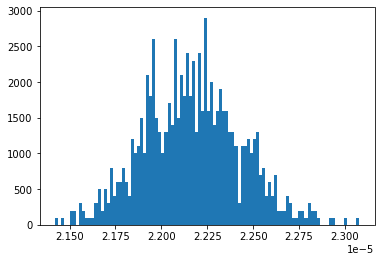

In [6]:
bm_samples = posterior_samples["bm"]
gamma = 65 / 0.511
norm_emit_samples = torch.det(bm_samples).flatten().sqrt()
emit_samples = norm_emit_samples * A * gamma
print(emit_samples.mean())
print(emit_samples.std())
plt.hist(emit_samples.numpy(), bins=100);